<a href="https://colab.research.google.com/github/Mikceroese/GPianoroll/blob/main/MuseGAN_DBG_chroma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Music with GANs

The following is a modified version of the PyTorch implementation of *MuseGAN*, by Dong et al.

The official repository for the paper can be found at https://github.com/salu133445/musegan, and the original PyTorch implementation in Colab is available at https://github.com/salu133445/ismir2019tutorial.

*ON MODIFICATIONS:*

This notebook is part of the material for *Random rotational embedding Bayesian optimization for human-in-the-loop music generation*, by Marcos et al. submitted to the Plos ONE journal. It includes code for (down)loading the data, trainig the model, and performing inference.

This version is a reduced version of the GAN, which only uses Drums, Bass and Guitar. This change is intended to reduce the dimensionality and adapt it for human-on-the-loop. It also uses bigger latent vectors to compensate the lower number of instruments with more variety.

This modified notebook includes new cells for inference, as well as metric extraction functions emulating the ones proposed in the original code. The model is saved using checkpoints, which allows to restore it for later training or inference, and also saves RAM. This allows to train with more samples than in the original notebook.

*ON METRICS:*

The notebook uses different (smaller) tensor sizes than the presented on the paper to account for RAM limitations in Colab. This means the metrics are affected due to downsampling, so expect some mismatch between these and the reported values from the original work. We aim for the values reported by the data, not the ones from the paper.

The Drum Pattern metric has been ignored and the Qualified Note % is trivial (the model can't generate notes that would be short enough to not be considered qualified). If you run this code locally and can afford higher time resolution, feel free to implement them.

Notebook modified by Miguel Marcos (mikceroese @GitHub https://github.com/Mikceroese), University of Zaragoza, Spain.

## Prerequisites

### Install dependencies

In [ ]:
!pip3 install torch matplotlib tqdm gdown "pypianoroll>=1.0.2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.1 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=4a01bb0ba539bb9326791f8bfb186c91d29a8d0398626750120110c29e40a593
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


### Import libraries

In [ ]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm

## Settings

In [ ]:
#@title Instrument settings
n_tracks = 3  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 18  # number of samples to extract from each song in the dataset
programs = [0, 25, 33]  # program number for each track
is_drums = [True, False, False]  # drum indicator for each track
track_names = ['Drums', 'Guitar', 'Bass']  # name of each track

note_thresholds = np.array([0.999,0.7415,0.7416])  # Values lower than this are considered silence.
                      # Note that this value directly influences metrics.

assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)

In [ ]:
#@title Tempo settings
tempo = 100
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
n_beats_per_measure = 4
measure_resolution = beat_resolution * n_beats_per_measure
tempo_array = np.full((4 * n_measures * measure_resolution, 1), tempo)

assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)

In [ ]:
#@title Training settings

# Training
batch_size = 32
latent_dim = 128 # Size of the latent vector fed to the generator
n_steps = 25000 # The models trains over a set number of steps rather than epochs
eval_interval = 100 # Run metric evaluation every x steps
loss_log_interval = 50 # Log loss to Tensorboard every x steps

disc_passes = 5 # Passes for the discriminator and the generator. If one of them
gen_passes = 1 # falls behind, you can try giving them more passes per step.

# Sampling
save_interval = 500

n_samples = 4 # Samples to show when extracting examples. (The tempo array is
              # hardcoded to show 16 measures (4 measures x 4 samples) so you may need
              # to change it if you use other number than 4)

## Metric extraction functions

In [ ]:
#@title Empty Bar ratio (EB%)
def empty_bar_ratio(samples_np,verbose=True):
  """
  Samples are supposed to be a numpy array of shape [n,i,t,p] where
  · n is the number of samples
  · i is the number of instruments (tracks)
  · t is the timestep resolution (beat_resolution*beats_per_measure*measures)
  · p is the pitch dimension
  """

  torch.cuda.empty_cache()

  s = samples_np.shape
  samples = torch.from_numpy(samples_np)
  if torch.cuda.is_available():
      samples = samples.cuda()
  sample_bars = samples.view(s[0],s[1],s[2]//measure_resolution,measure_resolution,s[3])
  s = sample_bars.size()
  total_bars_per_track = s[0]*s[2]

  """
  sample_bars is now of shape [n,i,m,b,p] where
  · m is the number of measures per sample
  · b is the timesteps in a measure (beat_resolution*beats_per_measure)
  """

  """
  # Turn binary representation of pitch into pitch count
  non_zero_pitches = torch.count_nonzero(sample_bars,dim=4)
  # If atleast one pitch is present, the beat is not empty
  non_empty_beats = torch.count_nonzero(non_zero_pitches,dim=3)
  # If atleast one beat is not empty, the bar is not empty
  non_empty_bars = torch.count_nonzero(non_empty_beats,dim=2)
  """
  non_empty_bars = torch.count_nonzero(
                      torch.count_nonzero(
                          torch.count_nonzero(sample_bars, dim = 4),
                          dim = 3
                      ),
                      dim = 2
                   )

  ebrs=[]

  for i in range(s[1]):
    empty_bars_per_track = total_bars_per_track
    for n in range(s[0]):
      empty_bars_per_track-=non_empty_bars[n,i]
    EBr = empty_bars_per_track/total_bars_per_track
    EBr = EBr.item()
    if verbose:
      print("Empty Bar ratio for",track_names[i],":")
      print(EBr)
    ebrs.append(EBr)

  del non_empty_bars
  del sample_bars
  del samples
  torch.cuda.empty_cache()

  return np.array(ebrs)

def empty_bar_ratio_lowmem(samples_np,verbose=True,splits=4):

  ebrs=np.zeros(samples_np.shape[1])
  split_size=samples_np.shape[0]//4
  for i in range(splits):
    if i==(splits-1):
      ebrs+=empty_bar_ratio(samples_np[i*split_size:],verbose=False)
    else:
      ebrs+=empty_bar_ratio(samples_np[i*split_size:(i+1)*split_size],verbose=False)
  ebrs/=splits
  if verbose:
    for i in range(samples_np.shape[1]):
      print("Empty Bar ratio for",track_names[i],":")
      print(ebrs[i])
  return ebrs

In [ ]:
#@title Used Pitch Classes (UPC)
def used_pitch_classes(samples_np,verbose=True):
  """
  Samples are supposed to be a numpy array of shape [n,i,t,p] where
  · n is the number of samples
  · i is the number of instruments (tracks)
  · t is the timestep resolution (beat_resolution*beats_per_measure*measures)
  · p is the pitch dimension
  """

  torch.cuda.empty_cache()

  s = samples_np.shape
  samples = torch.from_numpy(samples_np)
  if torch.cuda.is_available():
      samples = samples.cuda()
  sample_bars = samples.view(s[0],s[1],s[2]//measure_resolution,measure_resolution,s[3]//12,12)
  s = sample_bars.size()

  """
  sample_bars is now of shape [n,i,m,b,s,p] where
  · m is the number of measures per sample
  · b is the timesteps in a measure (beat_resolution*beats_per_measure)
  · s is the scale of the pitch
  """

  """
  # In the original paper, same pitch at different scales is counted only once
  # (This is inferred from the presented metrics but not actually discussed in the text)
  scaled_pitch_hist = torch.sum(sample_bars,dim=4)
  # Sum all pitch appearances over the beats of each measure
  pitch_hist = torch.sum(scaled_pitch_hist,dim=3)
  # If a pitch appears atleast once in a bar, it is counted
  pitches_per_bar = torch.count_nonzero(pitch_hist,dim=3).type(torch.float)
  # Average over all measure of each sample
  avg_p_per_sample = torch.mean(pitches_per_bar,dim=2)
  # Average over all samples
  avg_p_per_track = torch.mean(avg_p_per_sample,dim=0)
  """
  avg_p_per_track = torch.mean(
                      torch.mean(
                          torch.count_nonzero(
                              torch.sum(
                                  torch.sum(sample_bars,dim=4),
                                  dim = 3
                              ), dim = 3
                          ).type(torch.float),
                          dim = 2
                      ),
                      dim = 0
                    )

  upcs=[]

  for i in range(s[1]):
    if track_names[i]=="Drums": continue
    upc = avg_p_per_track[i].item()
    if verbose:
      print("Used pitch classes for",track_names[i],":")
      print(upc)
    upcs.append(upc)

  del avg_p_per_track
  del sample_bars
  del samples
  torch.cuda.empty_cache()

  return np.array(upcs)

def used_pitch_classes_lowmem(samples_np,verbose=True,splits=4):

  upcs=np.zeros(samples_np.shape[1]-1)
  split_size=samples_np.shape[0]//4
  for i in range(splits):
    if i==(splits-1):
      upcs+=used_pitch_classes(samples_np[i*split_size:],verbose=False)
    else:
      upcs+=used_pitch_classes(samples_np[i*split_size:(i+1)*split_size],verbose=False)
  upcs/=splits
  if verbose:
    for i in range(1,samples_np.shape[1]):
        print("Used pitch classes for",track_names[i],":")
        print(upcs[i-1])

  return upcs

In [ ]:
#@title Tonal Distance (TD)
r1=1.0 ; r2=1.0 ; r3 = 0.5
tm = np.empty((6, 12), dtype=np.float32)
tm[0, :] = r1*np.sin(np.arange(12)*(7./6.)*np.pi)
tm[1, :] = r1*np.cos(np.arange(12)*(7./6.)*np.pi)
tm[2, :] = r2*np.sin(np.arange(12)*(3./2.)*np.pi)
tm[3, :] = r2*np.cos(np.arange(12)*(3./2.)*np.pi)
tm[4, :] = r3*np.sin(np.arange(12)*(2./3.)*np.pi)
tm[5, :] = r3*np.cos(np.arange(12)*(2./3.)*np.pi)

def to_chroma(bar):
  chroma = bar.reshape(bar.shape[0], 12, -1).sum(axis=2)
  return chroma

def tonal_dist(beat_chroma1, beat_chroma2):
  beat_chroma1 = beat_chroma1 / np.sum(beat_chroma1)
  c1 = np.matmul(tm, beat_chroma1)
  beat_chroma2 = beat_chroma2 / np.sum(beat_chroma2)
  c2 = np.matmul(tm, beat_chroma2)
  return np.linalg.norm(c1-c2)

def bar_tonal_distance(chroma1, chroma2):
  chr1 = np.sum(chroma1, axis=0)
  chr2 = np.sum(chroma2, axis=0)
  return tonal_dist(chr1,chr2)

def tonal_distance(samples_np,verbose=True):
  """
  Samples are supposed to be a numpy array of shape [n,i,t,p] where
  · n is the number of samples
  · i is the number of instruments (tracks)
  · t is the timestep resolution (beat_resolution*beats_per_measure*measures)
  · p is the pitch dimension
  """

  torch.cuda.empty_cache()

  s = samples_np.shape
  bars = samples_np.view().reshape((s[0],s[1],s[2]//measure_resolution,measure_resolution,s[3]))
  s = bars.shape

  """
  bars is now of shape [n,i,m,b,p] where
  · m is the number of measures per sample
  · b is the timesteps in a measure (beat_resolution*beats_per_measure)
  """
  scores = np.zeros((s[1]-1)*(s[1]-2)//2)
  current_combo = 0

  for t1 in range(1,s[1]):
    for t2 in range(t1+1,s[1]):
      total_bars = s[0]*s[2]
      for n in range(s[0]):
        for m in range(s[2]):
          bar1 = bars[n,t1,m,:,:]
          chroma1 = to_chroma(bar1)
          if (np.sum(chroma1)==0.0):
            total_bars-=1
            continue
          bar2 = bars[n,t2,m,:,:]
          chroma2 = to_chroma(bar2)
          if (np.sum(chroma2)==0.0):
            total_bars-=1
            continue
          scores[current_combo] += bar_tonal_distance(chroma1,chroma2)
        # end for m
      # end for n
      if (total_bars==0):
        scores[current_combo]=0
      else:
        scores[current_combo]/=total_bars
      if verbose:
        print("Tonal distance",track_names[t1],"-",track_names[t2],":",scores[current_combo])
      current_combo+=1
    # end for t2
  # end for t1

  return scores

##Plotting functions

In [ ]:
def samples_to_multitrack(samples):

  samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
  tracks = []
  for idx, (program, is_drum, track_name) in enumerate(
      zip(programs, is_drums, track_names)
  ):
      pianoroll = np.pad(
          samples[idx] > 0.5,
          ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
      )
      tracks.append(
          Track(
              name=track_name,
              program=program,
              is_drum=is_drum,
              pianoroll=pianoroll
          )
      )
  m = Multitrack(
      tracks=tracks,
      tempo=tempo_array,
      resolution=beat_resolution
  )

  return m

In [ ]:
def plot_multitrack(m):
  axs = m.plot()
  plt.gcf().set_size_inches((16, 8))
  for ax in axs:
      for x in range(
          measure_resolution,
          4 * measure_resolution * n_measures,
          measure_resolution
      ):
          if x % (measure_resolution * 4) == 0:
              ax.axvline(x - 0.5, color='k')
          else:
              ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
  plt.show()

## Data Preparation (if not saved to .npy)

### Download the Lakh Pianoroll Dataset (LPD)

In [ ]:
!mkdir -p data

!gdown -O data/lpd_5_cleansed.tar.gz https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5
!gdown -O data/id_lists_amg.tar.gz https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R
!gdown -O data/id_lists_lastfm.tar.gz https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO

!tar zxf data/lpd_5_cleansed.tar.gz -C data/
!tar zxf data/id_lists_amg.tar.gz -C data/
!tar zxf data/id_lists_lastfm.tar.gz -C data/

Downloading...
From: https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5
To: /content/data/lpd_5_cleansed.tar.gz
100% 555M/555M [00:17<00:00, 32.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R
To: /content/data/id_lists_amg.tar.gz
100% 63.9k/63.9k [00:00<00:00, 146MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO
To: /content/data/id_lists_lastfm.tar.gz
100% 668k/668k [00:00<00:00, 144MB/s]


In [ ]:
dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
id_list = []
for path in os.listdir("data/amg"):
    filepath = os.path.join("data/amg", path)
    if os.path.isfile(filepath):
        with open(filepath) as f:
            id_list.extend([line.rstrip() for line in f])
id_list = list(set(id_list))

In [ ]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

### Visualize an example of pianorolls in LPD

In [ ]:
song_dir = dataset_root / msd_id_to_dirs('TRQAOWZ128F93000A4') # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
multitrack.trim(end=12 * 96)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(96, 12 * 96, 96):
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [ ]:
# Save the MIDI for listening
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
midi_path = "/content/gdrive/MyDrive/DJ-GAN/Example/sample_2.mid"
multitrack.write(midi_path)

### Collect training data

In [ ]:
data = []
# Iterate over all the songs in the ID list
for msd_id in tqdm(id_list):
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root / msd_id_to_dirs(msd_id)
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        sample = pianoroll[[0,2,3], start:end] # Keep only drums, guitar and bass
        # Skip the samples where some track(s) has too few notes
        if (sample.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(sample)

# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# Change the destination of the data as desired
np.save("/content/gdrive/MyDrive/musegan_samples_DBG",data)

## Load the data from .npy (if saved)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# Change the route of the data as needed
data = np.load("/content/gdrive/MyDrive/musegan_samples_DBG.npy")
print(data.shape)

## Metrics and examples

In [ ]:
print("---Empty Bar Ratio---")
ebr = empty_bar_ratio_lowmem(data)

In [ ]:
print("---Used Pitch Classes---")
upc = used_pitch_classes_lowmem(data)

In [ ]:
print("---Tonal Distance scores---")
td = tonal_distance(data)

### Visualize an example of training samples

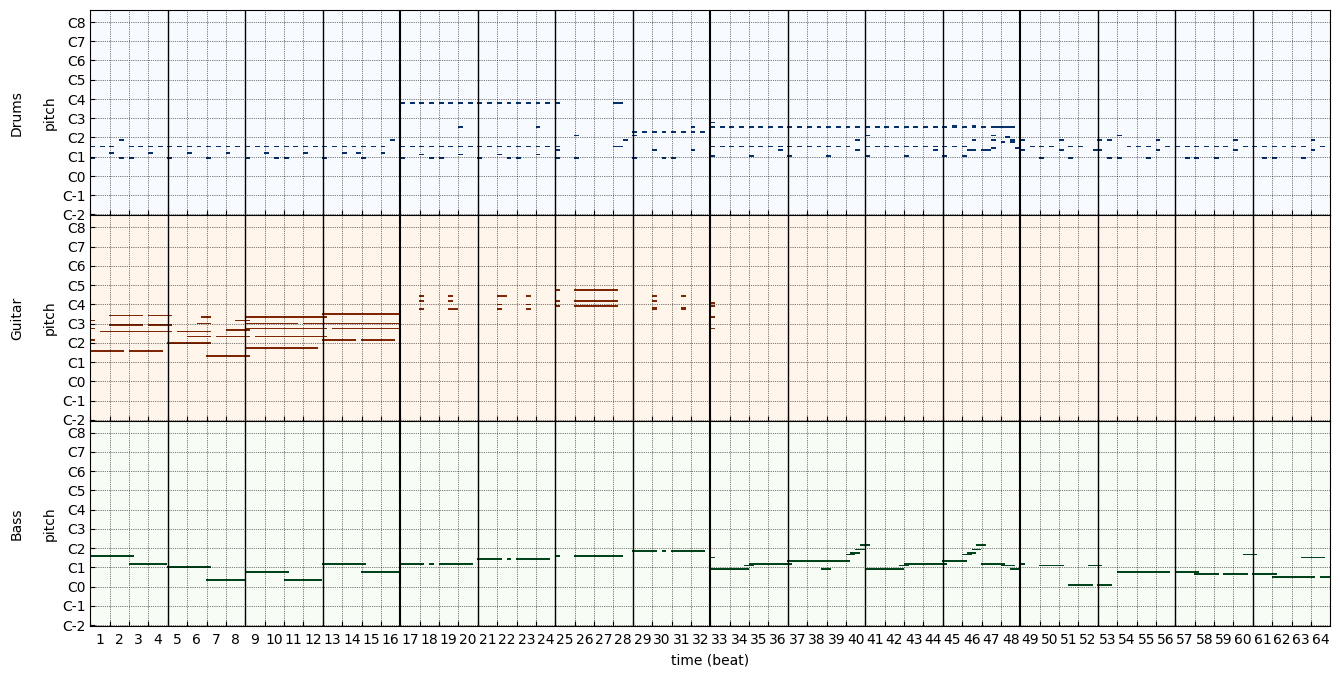

In [ ]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

## Create dataset and data loader

In [ ]:
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## Model definition

 ### Define the generator

In [ ]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super(GeneratorBlock,self).__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
        self.silu = torch.nn.SiLU()

    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        x = self.silu(x)
        return x

In [ ]:
class OutputBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super(OutputBlock,self).__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.transconv(x)
        x = self.sig(x)
        return x


In [ ]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector for all tracks and a per-track latent vector,
    then outputs a fake sample."""
    def __init__(self):
        super().__init__()

        # Shared network
        self.transconv0 = GeneratorBlock(latent_dim, 256, (4, 1, 1), (4, 1, 1)) # 4, 1, 1
        self.transconv1 = GeneratorBlock(256, 128, (1, 4, 3), (1, 4, 3)) # 4, 4, 3
        self.transconv2 = GeneratorBlock(128, 64, (1, 2, 2), (1, 2, 2)) # 4, 8, 6

        # Private pitch-time network
        self.pt_transconv3 = torch.nn.ModuleList([
            GeneratorBlock(64, 16, (1, 1, 12), (1, 1, 12)) # 4, 8, 72
            for _ in range(n_tracks)
        ])
        self.pt_transconv4 = torch.nn.ModuleList([
            GeneratorBlock(16, 1, (1, 2, 1), (1, 2, 1)) # 4, 16, 72
            for _ in range(n_tracks)
        ])

        # Private time-pitch network
        self.tp_transconv3 = torch.nn.ModuleList([
            GeneratorBlock(64, 16, (1, 2, 1), (1, 2, 1)) # 4, 16, 6
            for _ in range(n_tracks)
        ])
        self.tp_transconv4 = torch.nn.ModuleList([
            GeneratorBlock(16, 1, (1, 1, 12), (1, 1, 12)) # 4, 16, 72
            for _ in range(n_tracks)
        ])

        # Merge and output
        self.transconv5 = torch.nn.ModuleList([
            OutputBlock(2,1,(1,1,1),(1,1,1)) # 4, 16, 72
            for _ in range(n_tracks)
        ])

    def forward(self, x):
        # Shared network
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        # Private pitch-time network
        x_pt = [transconv(x) for transconv in self.pt_transconv3]
        x_pt = torch.cat([transconv(x_) for x_, transconv in zip(x_pt, self.pt_transconv4)], 1)
        # Private time-pitch network
        x_tp = [transconv(x) for transconv in self.tp_transconv3]
        x_tp = torch.cat([transconv(x_) for x_, transconv in zip(x_tp, self.tp_transconv4)], 1)
        # Merge and output
        # Probably not the most elegant solution, but it's the only one
        # I could figure out. Tensors and convolutions are really annoying
        x = [torch.cat([torch.unsqueeze(x_pt[:,i],1),
                        torch.unsqueeze(x_tp[:,i],1)],1)
                        for i in range(n_tracks)]

        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)],1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

 ### Define the discriminator

In [ ]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [ ]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.conv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
        self.lrelu = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.layernorm(x)
        return self.lrelu(x)

In [ ]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # Comments next to layers indicate the shape of the output,
        # in the form <M,T,P> (Measure,Time,Pitch)

        # Mirror the private time-pitch network (so now it's pitch-time)
        self.pt_conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks) # 4, 16, 6
        ])
        self.pt_conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 64, (1, 2, 1), (1, 2, 1)) for _ in range(n_tracks) # 4, 8, 6
        ])
        # Mirror the private pitch-time network (so now it's time-pitch)
        self.tp_conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 2, 1), (1, 2, 1)) for _ in range(n_tracks) # 4, 8, 72
        ])
        self.tp_conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 64, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks) # 4, 8, 6
        ])
        # Mirror the shared network
        self.conv2 = DiscriminatorBlock(64 * n_tracks * 2, 128, (1, 2, 2), (1, 2, 2)) # 4, 4, 3
        self.conv3 = DiscriminatorBlock(128, 256, (1, 4, 3), (1, 4, 3)) # 4, 1, 1

        # Chroma stream
        self.chroma_conv0 = DiscriminatorBlock(n_tracks,64,(1,1,12),(1,1,12)) # 4, 4, 1
        self.chroma_conv1 = DiscriminatorBlock(64,128,(1,4,1),(1,4,1)) # 4, 1, 1

        # Onset/Offset stream
        self.onoff_conv0 = DiscriminatorBlock(n_tracks,64,(1,4,1),(1,4,1)) # 4, 4, 1
        self.onoff_conv1 = DiscriminatorBlock(64,128,(1,4,1),(1,4,1)) # 4, 1, 1

        # Merge streams
        self.conv4 = DiscriminatorBlock(512, 256, (2, 1, 1), (1, 1, 1)) # 3, 1, 1
        self.conv5 = DiscriminatorBlock(256, latent_dim, (3, 1, 1), (3, 1, 1)) # 1, 1, 1

        # Final output
        self.dense1 = torch.nn.Linear(latent_dim, 1)

    def forward(self, x):

        # x has shape <B,I,T,P>
        # (Batch, Instrument, Time and Pitch)
        # Instruments are considered channels

        # Extract chroma feature
        chroma = x.view(-1, n_tracks, n_measures, n_beats_per_measure, beat_resolution, n_pitches)
        chroma = torch.sum(chroma,4) # 4, 4, 72
        chroma = chroma.view(-1, n_tracks, n_measures, n_beats_per_measure, n_pitches//12, 12)
        chroma = torch.sum(chroma,4) # 4, 4, 6

        # Extract onset/offset feature
        # Heads-up: PyTorch's padding starts from the last dimension.
        # We want to pad the Time dimension (second to last)
        # (0,0,1,0) means "Don't pad the Pitch dimension, add 1 padding
        # at the top of the Time dimension".
        onoff = torch.nn.functional.pad(x[:,:,:-1],(0,0,1,0))
        onoff = x - onoff
        onoff = onoff.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        onoff = torch.sum(onoff,4,keepdim=True) # 4, 16, 1

        # Compute the private instrument networks
        x = x.view(-1, n_tracks, 1, n_measures, measure_resolution, n_pitches)
        # Pitch-time
        x_pt = [conv(x[:,i]) for i, conv in enumerate(self.pt_conv0)]
        x_pt = torch.cat([conv(x_) for x_, conv in zip(x_pt, self.pt_conv1)], 1)
        # Time-pitch
        x_tp = [conv(x[:,i]) for i, conv in enumerate(self.tp_conv0)]
        x_tp = torch.cat([conv(x_) for x_, conv in zip(x_tp, self.tp_conv1)], 1)
        # Shared network
        x = torch.cat([x_pt,x_tp],1)
        x = self.conv2(x)
        x = self.conv3(x)

        # Chroma stream
        c = self.chroma_conv0(chroma)
        c = self.chroma_conv1(c)

        # Osset/offset stream
        o = self.onoff_conv0(onoff)
        o = self.onoff_conv1(o)

        # Merge streams
        x = torch.cat([x,c,o],1)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, latent_dim)
        x = self.dense1(x)
        return x

## Training functions

In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty helps stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    if torch.cuda.is_available():
      alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    else:
      alpha = torch.rand(real_samples.size(0), 1, 1, 1)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    if torch.cuda.is_available():
      fake = torch.ones(real_samples.size(0), 1).cuda()
    else:
      fake = torch.ones(real_samples.size(0), 1)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
def train_one_step(d_optimizer, g_optimizer, step):
    """Train the networks for one step."""

    if step>10:
        dp = disc_passes # The critic should train more than the generator
    else:
        dp = disc_passes*10 # Even more at the beginning

    for _ in range(dp):
        # === Train the discriminator ===

        real_samples = next(iter(data_loader))[0]
        latent = torch.randn(batch_size, latent_dim)

        # Transfer data to GPU
        if torch.cuda.is_available():
            real_samples = real_samples.cuda()
            latent = latent.cuda()

        # Reset cached gradients to zero
        d_optimizer.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = discriminator(real_samples)
        # Compute the loss function
        d_loss_real = -torch.mean(prediction_real)
        # Backpropagate the gradients
        d_loss_real.backward()

        # Generate fake samples with the generator
        fake_samples = generator(latent)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = discriminator(fake_samples.detach())
        # Compute the loss function
        d_loss_fake = torch.mean(prediction_fake_d)
        # Backpropagate the gradients
        d_loss_fake.backward()

        # Compute gradient penalty
        gradient_penalty = 10.0 * compute_gradient_penalty(
            discriminator, real_samples.data, fake_samples.data)
        # Backpropagate the gradients
        gradient_penalty.backward()

        # Update the weights
        d_optimizer.step()

    for _ in range(gen_passes):
        # === Train the generator ===
        # Reset cached gradients to zero
        g_optimizer.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = discriminator(fake_samples)
        # Compute the loss function
        g_loss = -torch.mean(prediction_fake_g)
        # Backpropagate the gradients
        g_loss.backward()
        # Update the weights
        g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Model Instantiation

In [ ]:
# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.6, 0.95))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.6, 0.95))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to store history samples
history_samples = {}

# Initialize step
step = 0

## Defining Checkpoints

In [ ]:
def save_checkpoint(gen_path,disc_path):

    torch.save({
        'epoch':step,
        'model_state_dict':generator.state_dict(),
        'optimizer_state_dict':g_optimizer.state_dict(),
        'loss':g_loss
    },gen_path)

    torch.save({
        'epoch':step,
        'model_state_dict':discriminator.state_dict(),
        'optimizer_state_dict':d_optimizer.state_dict(),
        'loss':d_loss
    },disc_path)


In [ ]:
#@title Basic checkpoint (every x steps)

# Checkpoint to save
gen_checkpoint_path = "/content/gdrive/MyDrive/Model_checkpoints/powgan_gen.pt"
disc_checkpoint_path = "/content/gdrive/MyDrive/Model_checkpoints/powgan_disc.pt"

## Recovering Checkpoint

In [ ]:
# Load the checkpoints from the path

# Checkpoint to load
gen_start_checkpoint_path = gen_checkpoint_path
disc_start_checkpoint_path = disc_checkpoint_path

# Import the state dictionaries to the generator and discriminator
if torch.cuda.is_available():
  device = torch.device('cuda')
  gen_checkpoint = torch.load(gen_start_checkpoint_path)
  disc_checkpoint = torch.load(disc_start_checkpoint_path)
else:
  device = torch.device('cpu')
  gen_checkpoint = torch.load(gen_start_checkpoint_path, map_location=device)
  disc_checkpoint = torch.load(disc_start_checkpoint_path, map_location=device)

generator.load_state_dict(gen_checkpoint['model_state_dict'])
discriminator.load_state_dict(disc_checkpoint['model_state_dict'])
g_optimizer.load_state_dict(gen_checkpoint['optimizer_state_dict'])
d_optimizer.load_state_dict(disc_checkpoint['optimizer_state_dict'])

g_loss = gen_checkpoint['loss']
d_loss = disc_checkpoint['loss']
step = gen_checkpoint['epoch']

##Prepare samples for test and metrics

In [ ]:
# Number of samples for metric estimation
n_samples_metrics = 5000
sample_latent_m = torch.randn(n_samples_metrics, latent_dim)
# Transfer samples to GPU
if torch.cuda.is_available():
    sample_latent_m = sample_latent_m.cuda()

## Training

In [ ]:
# Install latest Tensorflow build for tensorboard
!pip install -q tensorflow
from tensorflow import summary
import datetime
%load_ext tensorboard

In [ ]:
# Remove last logging directory (in case the experiment was interrupted or not valid for some reason)
!rm -r $train_log_dir

In [ ]:
# Prepare new directory for logging
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = '/content/logs/tensorboard/train/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)

In [ ]:
%tensorboard --logdir /content/logs/tensorboard

In [ ]:
# Log target values into Tensorboard
target_log_dir = '/content/logs/tensorboard/target'
target_summary_writer = summary.create_file_writer(target_log_dir)
with target_summary_writer.as_default():
  summary.scalar('ebr-D',0.06406286731362343, step=0)
  summary.scalar('ebr-D',0.06406286731362343, step=n_steps)
  summary.scalar('ebr-G',0.20079166069626808, step=0)
  summary.scalar('ebr-G',0.20079166069626808, step=n_steps)
  summary.scalar('ebr-B',0.08722345717251301, step=0)
  summary.scalar('ebr-B',0.08722345717251301, step=n_steps)
  summary.scalar('upc-G',3.4373782873153687, step=0)
  summary.scalar('upc-G',3.4373782873153687, step=n_steps)
  summary.scalar('upc-B',2.259679079055786, step=0)
  summary.scalar('upc-B',2.259679079055786, step=n_steps)
  summary.scalar('td-BG',1.2755134814731182, step=0)
  summary.scalar('td-BG',1.2755134814731182, step=n_steps)


In [ ]:
metric_targets = torch.Tensor([0.06406286731362343,0.20079166069626808,0.08722345717251301,3.4373782873153687,2.259679079055786,1.2755134814731182])

In [ ]:
#@title Training loop
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, position=0, leave=True)

save_steps = range(0,n_steps+1,save_interval)
loss_log_steps = range(0,n_steps+1,loss_log_interval)
eval_steps = range(0,n_steps+1,eval_interval)

max_crit_loss = float('-inf')
min_metric_margin = float('inf')

# Start iterations
while step < n_steps + 1:

      # Train the neural networks
      generator.train()
      d_loss, g_loss = train_one_step(d_optimizer, g_optimizer,step)

      # Update losses to progress bar
      progress_bar.set_description_str(
          "(d_loss={: 4.6f}, g_loss={: 4.6f})".format(d_loss, g_loss))

      # Step check to prevent critic loss peaks at the beginning of training
      if step > 100 and d_loss.item() > max_crit_loss:
          max_crit_loss = d_loss.item()
          save_checkpoint(gen_maxcrit_checkpoint_path,disc_maxcrit_checkpoint_path)
          print("New critic loss maximum")

      if step in eval_steps:

          # Extract metrics from more samples
          generator.eval()
          samples = generator(sample_latent_m).cpu().detach().numpy()
          for i in range(n_tracks):
            samples[:,i][samples[:,i]<note_thresholds[i]]=0.0
          with train_summary_writer.as_default():
            ebr = empty_bar_ratio_lowmem(samples,verbose=False)
            upc = used_pitch_classes_lowmem(samples,verbose=False)
            td = tonal_distance(samples,verbose=False)
            for i in range(n_tracks):
              summary.scalar('ebr-'+track_names[i][0],ebr[i], step=step)
            for i in range(1,n_tracks):
              summary.scalar('upc-'+track_names[i][0],upc[i-1], step=step)
            summary.scalar('td-BG',td[0], step=step)

            metric_values = torch.cat([torch.tensor(ebr),torch.tensor(upc),torch.tensor(td)])
            metric_margin = (torch.nn.functional.mse_loss(metric_values,metric_targets).item() + torch.nn.functional.l1_loss(metric_values,metric_targets).item())/2

            if (metric_margin<min_metric_margin):
              min_metric_margin = metric_margin
              save_checkpoint(gen_bestmetrics_checkpoint_path,disc_bestmetrics_checkpoint_path)
              print("New metric margin minimum")

      if step in loss_log_steps:
          with train_summary_writer.as_default():
            summary.scalar('g_loss',g_loss.item(),step=step)
            summary.scalar('d_loss',d_loss.item(),step=step)

      if step in save_steps:

          # Get generated samples
          generator.eval()
          samples = generator(sample_latent).cpu().detach().numpy()
          history_samples[step] = samples

          # Display generated samples
          m = samples_to_multitrack(samples)
          plot_multitrack(m)

          save_checkpoint(gen_checkpoint_path,disc_checkpoint_path)

      step += 1
      progress_bar.update(1)
      if step >= n_steps:
          break

progress_bar.close()

In [ ]:
# Close the tqdm bar in case you interrupted the training in the cell above
progress_bar.close()

In [ ]:
# Save final model
torch.save({'epoch':step,
                'model_state_dict':generator.state_dict(),
                'optimizer_state_dict':g_optimizer.state_dict(),
                'loss':g_loss
            },gen_checkpoint_path)

torch.save({'epoch':step,
                'model_state_dict':discriminator.state_dict(),
                'optimizer_state_dict':d_optimizer.state_dict(),
                'loss':d_loss
            },disc_checkpoint_path)


In [ ]:
# Download the tensorboard events
!zip -r /content/logs.zip /content/logs

from google.colab import files
files.download("/content/logs.zip")

# Inference

In [ ]:
#@title Recover model
# Import the state dictionaries
if torch.cuda.is_available():
  device = torch.device('cuda')
  checkpoint = torch.load(gen_checkpoint_path)
else:
  device = torch.device('cpu')
  checkpoint = torch.load(gen_checkpoint_path, map_location=device)

generator.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# Set the generator into evaluation mode, generate a random tensor, get the samples
generator.eval()
latent = torch.randn(n_samples, latent_dim)
if torch.cuda.is_available():
  latent = latent.cuda()
samples = generator(latent).cpu().detach().numpy()
# The shape of the sample is (#num_samples,#tracks,#tempo_steps,#pitches)
print(samples.shape)

(4, 3, 64, 72)


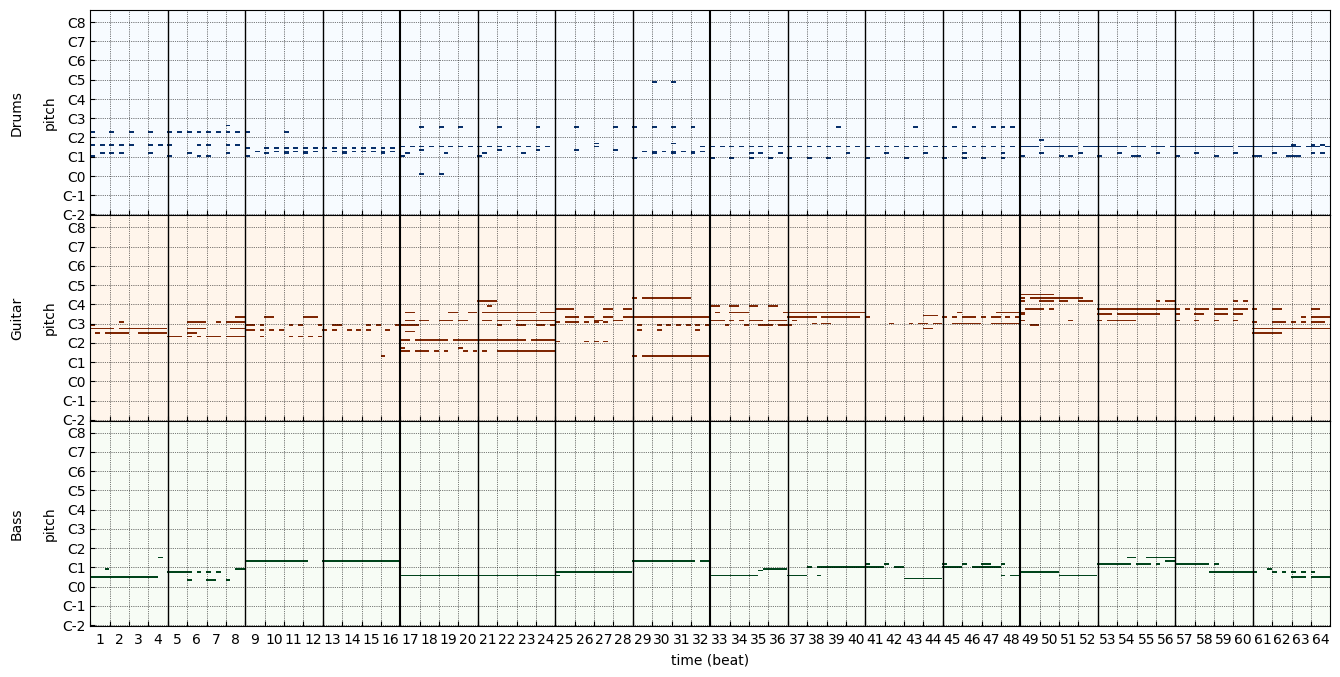

In [ ]:
# Generate the multitrack, plot, and save as MIDI

npz_path = "/content/gdrive/MyDrive/Generated/sample_powgan.npz"
midi_path = "/content/gdrive/MyDrive/Generated/sample_powgan.mid"

for i in range(n_tracks):
  samples[:,i][samples[:,i]<note_thresholds[i]]=0.0
m = samples_to_multitrack(samples)
plot_multitrack(m)
m.save(npz_path)
m = pypianoroll.load(npz_path)
# For some reason, m can't be written directly, due to some class definition problem,
# but saving to npz, loading and writing works.
m.write(midi_path)

# Metrics

In [ ]:
# Import the state dictionaries to the generator and discriminator
if torch.cuda.is_available():
  device = torch.device('cuda')
  gen_checkpoint = torch.load(gen_checkpoint_path)
else:
  device = torch.device('cpu')
  gen_checkpoint = torch.load(gen_checkpoint_path, map_location=device)

generator.load_state_dict(gen_checkpoint['model_state_dict'])

In [ ]:
generator.eval()
# Number of samples for metric estimation
n_samples_metrics = 5000
sample_latent_m = torch.normal(0.0,1.0,(n_samples_metrics, latent_dim))
# Transfer samples to GPU
if torch.cuda.is_available():
    sample_latent_m = sample_latent_m.cuda()
samples = generator(sample_latent_m).cpu().detach().numpy()
for i in range(n_tracks):
  samples[:,i][samples[:,i]<note_thresholds[i]]=0.0
# The shape of the sample is (#num_samples,#tracks,#tempo_steps,#pitches)
print(samples.shape)

In [ ]:
avg_sample = np.mean(samples,axis=0)
var_sample = np.mean(np.multiply(samples-avg_sample,samples-avg_sample),axis=0)

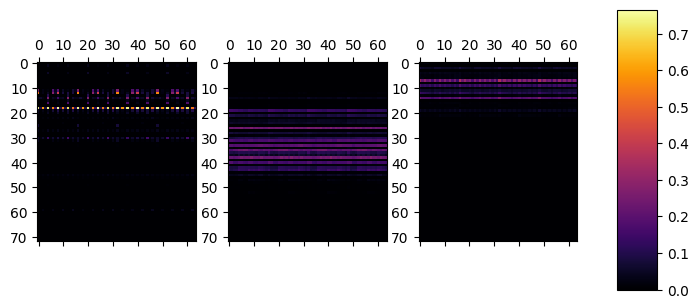

In [ ]:
# (The more values are colored, the better. It probably means the GAN didn't fall into Mode Collapse)
# (Either that or just plays many notes at once, judge by looking at / listening to samples)
fig, ax = plt.subplots(1,3,figsize=(8,4))
vmax = np.max(avg_sample)
im1 = ax[0].matshow(avg_sample[0].T, cmap=plt.cm.inferno,vmin=0, vmax=vmax)
_ = ax[1].matshow(avg_sample[1].T, cmap=plt.cm.inferno,vmin=0, vmax=vmax)
_ = ax[2].matshow(avg_sample[2].T, cmap=plt.cm.inferno,vmin=0, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)


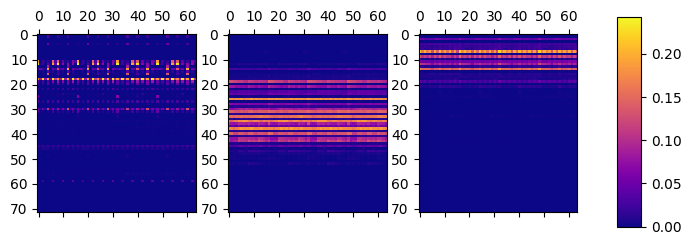

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(8,3))
vmax = np.max(var_sample)
im1 = ax[0].matshow(var_sample[0].T, cmap=plt.cm.plasma,vmin=0, vmax=vmax)
_ = ax[1].matshow(var_sample[1].T, cmap=plt.cm.plasma,vmin=0, vmax=vmax)
_ = ax[2].matshow(var_sample[2].T, cmap=plt.cm.plasma,vmin=0, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im1, cax=cbar_ax)

In [ ]:
generator.eval()
samples = generator(sample_latent_m).cpu().detach().numpy()
for i in range(n_tracks):
  samples[:,i][samples[:,i]<note_thresholds[i]]=0.0
ebr = empty_bar_ratio(samples)
print("Dataset values:",metric_targets[0:3].numpy(),"\n")
upc = used_pitch_classes(samples)
print("Dataset values:",metric_targets[3:5].numpy(),"\n")
td = tonal_distance(samples)
print("Dataset values:",metric_targets[5].numpy(),"\n")
metric_values = torch.cat([torch.tensor(ebr),torch.tensor(upc),torch.tensor(td)])
metric_margin = torch.nn.functional.l1_loss(metric_values,metric_targets).item()
print("MAE wrt. dataset metrics:",metric_margin)

In [ ]:
def get_metrics(samples):
  ebr = empty_bar_ratio(samples,verbose=False)
  upc = used_pitch_classes(samples,verbose=False)
  td = tonal_distance(samples,verbose=False)
  metric_values = torch.cat([torch.tensor(ebr),torch.tensor(upc),torch.tensor(td)])
  return metric_values